In [1]:
import rfpipe
# Updated for rfpipe version 1.3.1
from rfpipe import candidates
import numpy as np 
import pylab as plt
import matplotlib
import sys
import logging
from matplotlib import gridspec

logger = logging.getLogger()
logger = logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(threadName)s - %(levelname)s -'
                                                        ' %(message)s')
%matplotlib inline

In [2]:
params = {
        'axes.labelsize' : 14,
        'font.size' : 9,
        'legend.fontsize': 12,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'text.usetex': False,
        'figure.figsize': [20, 15]
        }
matplotlib.rcParams.update(params)

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
def make_dmt(ft, dmi, dmf, dmsteps, chan_freqs, tsamp):
    dm_list = np.linspace(dmi, dmf, dmsteps)
    dmt = np.zeros((dmsteps, ft.shape[1]), dtype=np.float32)
    for ii, dm in enumerate(dm_list):
        dmt[ii, :] = dedispersedts(ft, chan_freqs, tsamp, dms=dm)
    return dmt

def dedispersedts(data, chan_freqs, tsamp, dms=None):
    nf, nt = data.shape
    assert nf == len(chan_freqs)
    delay_time = 4148808.0 * dms * (1 / (chan_freqs[0]) ** 2 - 1 / (chan_freqs) ** 2) / 1000
    delay_bins = np.round(delay_time / tsamp).astype('int64')
    ts = np.zeros(nt, dtype=np.float32)
    for ii in range(nf):
        ts += np.concatenate([data[ii,-delay_bins[ii]:], data[ii, :-delay_bins[ii]]])
    return ts

def dedisperse(data, chan_freqs, tsamp, dms=None):
    nf, nt = data.shape
    assert nf == len(chan_freqs)
    delay_time = 4148808.0 * dms * (1 / (chan_freqs[0]) ** 2 - 1 / (chan_freqs) ** 2) / 1000
    delay_bins = np.round(delay_time / tsamp).astype('int64')
    ft = np.zeros(data.shape, dtype=np.float32)
    for ii in range(nf):
        ft[ii, :] = np.concatenate([data[ii,-delay_bins[ii]:], data[ii, :-delay_bins[ii]]])
    return ft

def make_refinement_plots(cd, nsubbands = 4, save = False):
    try:
        assert nsubbands > 0 
    except AssertionError as err:
        logging.exception("nsubands should be greater than 0")
        raise err

    dtarr_ind = cd.loc[3]
    width_m = cd.state.dtarr[dtarr_ind]
    timewindow = cd.state.prefs.timewindow
    tsamp = cd.state.inttime*width_m
    dm = cd.state.dmarr[cd.loc[2]]
    ft_dedisp = np.flip(np.abs(cd.data[:,:,0].T) + np.abs(cd.data[:,:,1].T), axis=0)
    chan_freqs = np.flip(cd.state.freq*1000) #from high to low, MHz
    nf, nt = np.shape(ft_dedisp)

    # If timewindow is not set during search, set it equal to the number of time bins of candidate
    if nt != timewindow:
        logging.info(f'Setting timewindow equal to nt = {nt}')
        timewindow = nt

    if nf//nsubbands < 10:
        logging.warning('Subbands should have atleast 10 channels. Setting to default (nsubbands = 4)')
        nsubbands = 4

    try:
        assert nf == len(chan_freqs) 
    except AssertionError as err:
        logging.exception("Number of frequency channel in data should match the frequency list")
        raise err

    dispersed = dedisperse(ft_dedisp, chan_freqs, tsamp, -1*dm)

    if dm is not 0:
        dm_start = 0
        dm_end = 2*dm
    else:
        dm_start = -10
        dm_end = 10

    logging.info(f'Generating DM-time for DM range {dm_start:.2f} pc/cc to {dm_end:.2f} pc/cc')
    dmt = make_dmt(dispersed, dm_start, dm_end, 256, chan_freqs, tsamp) 

    subsnrs, subts, bands = calc_subband_info(ft_dedisp, chan_freqs, nsubbands)    
    logging.info(f'Generating time series of full band')
    ts_full = ft_dedisp.sum(0)
    logging.info(f'Calculating SNR of full band')
    snr_full = calc_snr(ts_full)

    to_print = []
    logging.info(f'candloc: {cd.loc}, dm: {dm:.2f}')
    to_print.append(f'candloc: {cd.loc}, dm: {dm:.2f}\n')
    logging.info(f'SNR of full band is: {snr_full:.2f}')
    to_print.append(f'SNR of full band is: {snr_full:.2f}\n')
    logging.info(f'Subbanded SNRs are:')    
    to_print.append(f'Subbanded SNRs are:\n')
    for i in range(nsubbands):
        logging.info(f'Band: {chan_freqs[bands[i][0]]:.2f}-{chan_freqs[bands[i][1]-1]:.2f}, SNR: {subsnrs[i]:.2f}')
        to_print.append(f'Band: {chan_freqs[bands[i][0]]:.2f}-{chan_freqs[bands[i][1]-1]:.2f}, SNR: {subsnrs[i]:.2f}\n')

    str_print = ''.join(to_print)

    ts = np.arange(timewindow)*tsamp
    
    gs = gridspec.GridSpec(4, 3, width_ratios=[4, 0.1, 2], height_ratios=[1, 1, 1, 1], wspace=0.02, hspace=0.15)
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[1, 0])
    ax3 = plt.subplot(gs[2, 0])
    ax4 = plt.subplot(gs[3, 0])
    ax11 = plt.subplot(gs[0, 1])
    ax22 = plt.subplot(gs[1, 1])
    ax33 = plt.subplot(gs[2, 1])
    ax44 = plt.subplot(gs[3, 1])
    ax5 = plt.subplot(gs[:, 2])

    x_loc = 0.1
    y_loc = 0.5

    for i in range(nsubbands):
        ax1.plot(ts, subts[i] - subts[i].mean(), label = f'Band: {chan_freqs[bands[i][0]]:.0f}-{chan_freqs[bands[i][1]-1]:.0f}')
    ax1.plot(ts, subts.sum(0) - subts.sum(0).mean(), 'k.', label = 'Full Band')
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3, fancybox=True, shadow=True)
    ax1.set_ylabel('Flux (Arb. units)')
    ax1.set_xlim(np.min(ts), np.max(ts))
    ax11.text(x_loc, y_loc, 'Time Series', fontsize=14, ha='center', va='center', wrap=True, rotation=-90)
    ax11.axis('off')

    ax2.imshow(ft_dedisp, aspect='auto', extent=[ts[0], ts[-1], np.min(chan_freqs), np.max(chan_freqs)])
    ax2.set_ylabel('Freq (GHz)')
    ax22.text(x_loc, y_loc, 'Dedispersed FT', fontsize=14, ha='center', va='center', wrap=True, rotation=-90)
    ax22.axis('off')

    ax3.imshow(dispersed, aspect='auto', extent=[ts[0], ts[-1], np.min(chan_freqs), np.max(chan_freqs)])
    ax3.set_ylabel('Freq (GHz)')
    ax33.text(x_loc, y_loc, 'Original dispersed FT', fontsize=14, ha='center', va='center', wrap=True, rotation=-90)
    ax33.axis('off')

    ax4.imshow(dmt, aspect='auto', extent=[ts[0], ts[-1], dm+1*dm, dm-dm])
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('DM')
    ax44.text(x_loc, y_loc, 'DM-Time', fontsize=14, ha='center', va='center', wrap=True, rotation=-90)
    ax44.axis('off')

    ax5.text(0.02, 0.8, str_print, fontsize=14, ha='left', va='top', wrap=True)
    ax5.axis('off')
    segment, candint, dmind, dtind, beamnum = cd.loc
    plt.tight_layout()
    if save==True:
        plt.savefig(f'cands_{cd.state.fileroot}_seg{segment}-i{candint}-dm{dmind}-dt{dtind}_refined.png', bbox_inches='tight')
    plt.show()
    
def calc_subband_info(ft, chan_freqs, nsubbands=4):
    nf, nt = ft.shape

    subbandsize = nf//nsubbands
    bandstarts = np.arange(1,nf,subbandsize) - 1
    subsnrs = np.zeros(nsubbands)
    subts = np.zeros((nsubbands, ft.shape[1]))
    bands = []
    for i in range(nsubbands):
        bandstart = i*subbandsize
        if i == nsubbands-1:
            bandend = nf-1
        else:
            bandend = (i+1)*subbandsize

        bands.append([bandstart, bandend])
        logging.info(f'Generating time series of band: {chan_freqs[bands[i][0]]:.0f}-{chan_freqs[bands[i][1]-1]:.0f}')
        subts[i, :] = ft[bandstart: bandend,:].sum(0)
        logging.info(f'Calculating SNR of band: {chan_freqs[bands[i][0]]:.0f}-{chan_freqs[bands[i][1]-1]:.0f}')
        subsnrs[i] = calc_snr(subts[i, :])
    return subsnrs, subts, bands
    
def madtostd(array):
    return 1.4826*np.median(np.abs(array-np.median(array)))

def calc_snr(ts):
    std =  madtostd(ts)
    if std == 0:
        logging.warning('Standard Deviation of time series is 0. SNR not defined.')
        snr = np.nan
        return snr

    noise_mask = (np.median(ts) - 3*std < ts) & (ts < np.median(ts) + 3*std)
    if noise_mask.sum() == len(ts):
        logging.warning('Time series is just noise, SNR = 0.')
        snr = 0
    else:
        mean_ts = np.mean(ts[noise_mask])
        std = madtostd(ts[noise_mask]-mean_ts)
        if std == 0:
            logging.warning('Noise Standard Deviation is 0. SNR not defined.')
        snr = np.max(ts[~noise_mask]-mean_ts)/std
    return snr


def max_timewindow(st):
    if st.prefs.maxdm is None:
        maxdm = 1000
    else:
        maxdm = st.prefs.maxdm
    return int(4148808.0 * maxdm * (1 / np.min(st.freq) ** 2 - 1 / np.max(st.freq) ** 2) / 1000 / 10**6 // st.inttime)

In [5]:
def run_pipeline(dataloc = 'somewhere',scan = -1, segment = -1, prefs = None, devicenum=0):
    st = rfpipe.state.State(sdmfile=dataloc, sdmscan=scan, inprefs=prefs)
    prefs['timewindow'] = max_timewindow(st)
    st = rfpipe.state.State(sdmfile=dataloc, sdmscan=scan, inprefs=prefs)
    if scan != -1 and segment != -1:
        cc = rfpipe.pipeline.pipeline_seg(st, segment=segment, devicenum=devicenum)
        return cc, st
    elif scan != -1 and segment == -1:
        cc = rfpipe.pipeline.pipeline_scan(st, devicenum=devicenum)
        return cc, st
    else:
        logging.error('Enter valid Inputs!')
    return None

# Set up data paths

In [8]:
# Parameters
sdmname = "realfast_19A-393_TEST_B2319.58591.88012140046_1555623667170"

In [9]:
datasetId = '{0}'.format('_'.join(sdmname.split('_')[1:-1]))
# set the paths to the data and gainfile
filepath = '/home/mctest/evla/mcaf/workspace/'
bdfdir = '/lustre/evla/wcbe/data/realfast/'
workdir = '/users/claw/cbehome/lustre_workdir/'
gainpath = '/home/mchammer/evladata/telcal/'
gainname = datasetId + '.GN'
for path, dirs, files in os.walk(gainpath):
    for f in filter(lambda x: gainname in x, files):
        gainfile = os.path.join(path, gainname)
        break

# Search on a larger timewindow 
### With RFI Flags

In [38]:
prefs={'gainfile': gainfile, 'saveplots': False, 'savenoise': False, 'savesols': False,
       'savecandcollection': False, 'savecanddata': False,
       'applyonlineflags': True, 'fftmode': 'cuda', 'clustercands': False}

st = rfpipe.state.State(sdmfile=os.path.join(filepath, sdmname), sdmscan=1, inprefs=prefs,
                        preffile='/lustre/aoc/observers/nm-10222/rfgpu/Refinement/realfast.yml', bdfdir=bdfdir)

st.prefs.timewindow = max_timewindow(st)

2019-05-09 14:21:15,816 - rfpipe.metadata - INFO - Reading metadata from /lustre/aoc/projects/fasttransients/staging/16A-459_TEST_1hr_000.57633.66130137732.scan7.cut, scan 7
2019-05-09 14:21:16,022 - rfpipe.state - INFO - Metadata summary:
2019-05-09 14:21:16,023 - rfpipe.state - INFO - 	 Working directory and fileroot: /lustre/aoc/observers/nm-10222/rfgpu/Refinement, 16A-459_TEST_1hr_000.57633.66130137732.scan7.cut.7.1
2019-05-09 14:21:16,023 - rfpipe.state - INFO - 	 Using scan 7, source FRB121102-off
2019-05-09 14:21:16,024 - rfpipe.state - INFO - 	 nants, nbl: 27, 351
2019-05-09 14:21:16,024 - rfpipe.state - INFO - 	 nchan, nspw: 224, 8
2019-05-09 14:21:16,026 - rfpipe.state - INFO - 	 Freq range: 2.496 -- 3.500
2019-05-09 14:21:16,026 - rfpipe.state - INFO - 	 Scan has 800 ints (4.0 s) and inttime 0.005 s
2019-05-09 14:21:16,027 - rfpipe.state - INFO - 	 2 polarizations: ['RR', 'LL']
2019-05-09 14:21:16,028 - rfpipe.state - INFO - 	 Ideal uvgrid npix=(1944, 2187) and res=104 (over

In [ ]:
cc = rfpipe.pipeline.pipeline_scan(st)

## Cluster Candidates

In [8]:
cc.prefs.clustercands = True
cc_clustered, clusterer = rfpipe.candidates.cluster_candidates(cc, returnclusterer=True)
rfpipe.candidates.visualize_clustering(cc_clustered, clusterer)

2019-05-09 14:08:08,405 - rfpipe.candidates - INFO - Clustering parameters set to (5,3) and downsampling in xy by 1.
2019-05-09 14:08:08,538 - rfpipe.candidates - INFO - Found 1 clusters and 0 unclustered candidates for min cluster size 5


Loading BokehJS ...

## Reproduce candidate, obtain canddata and refine

In [9]:
st.prefs.applyonlineflags = False

clusters = cc_clustered.array['cluster'].astype(int)
cl_rank, cl_count = candidates.calc_cluster_rank(cc_clustered)
calcinds = np.unique(np.where(cl_rank == 1)[0]).tolist()
logging.info("Reproducing cands at {0} cluster peaks of SNR: {1}".format(len(calcinds),
                                                                         cc_clustered.snrtot[calcinds]))

2019-05-09 14:15:33,436 - rfpipe.search - INFO - Calculating FFT wisdom...
2019-05-09 14:15:33,497 - rfpipe.source - INFO - Reading segment 0 of datasetId realfast_19A-331_sb35982945_1_1.58541.41868983796_1551267033395
2019-05-09 14:15:33,498 - rfpipe.source - INFO - Reading scan 1, segment 0/0, times 11:30:33.395 to 11:30:35.825
2019-05-09 14:15:33,499 - rfpipe.source - INFO - Reading 486 ints starting at int 0
2019-05-09 14:15:37,660 - rfpipe.source - INFO - Read data with zero fraction of 0.149 for segment 0
2019-05-09 14:15:39,631 - rfpipe.source - INFO - Not applying online flags.
2019-05-09 14:15:39,739 - rfpipe.source - INFO - Applying calibration with /lustre/aoc/projects/fasttransients/staging/19A-331_sb35982945_1_1.58541.41868983796.GN
2019-05-09 14:15:39,758 - rfpipe.calibration - INFO - Read telcalfile /lustre/aoc/projects/fasttransients/staging/19A-331_sb35982945_1_1.58541.41868983796.GN with 2 sources, 7 times, 16 IFIDs, and 25 antennas
2019-05-09 14:15:39,760 - rfpipe.ca

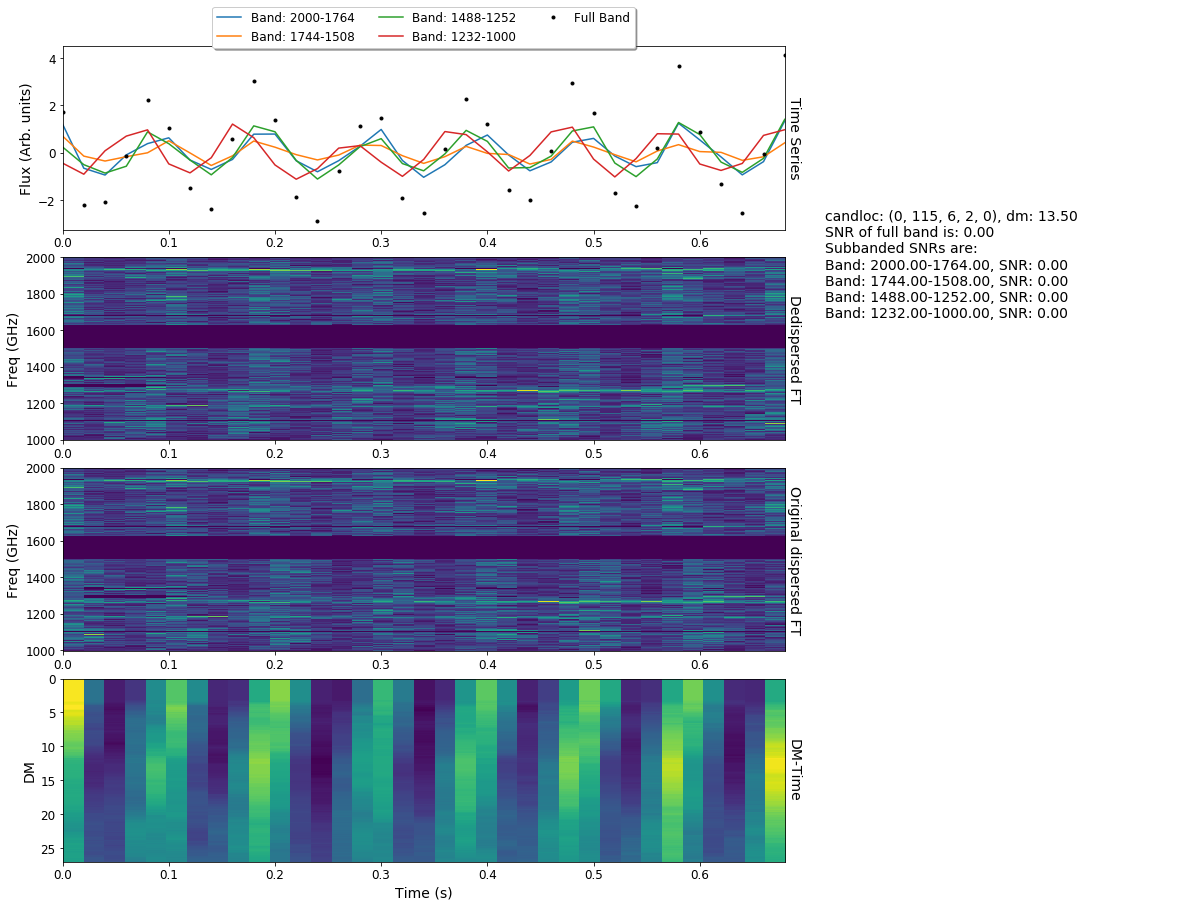

In [36]:
for ind in calcinds:
    candloc = cc_clustered.locs[ind]
    cd = rfpipe.reproduce.pipeline_canddata(st, candloc)
    make_refinement_plots(cd, nsubbands=4 ,save=False)

# Search with larger time window
## without online RFI flags

In [ ]:
#set the "refined" preferences
prefs={'gainfile': gainfile,
       'savecandcollection': False, 'savecanddata': False,
        'fftmode': 'cuda', 'clustercands': False, 'flaglist': []}

st = rfpipe.state.State(sdmfile=os.path.join(filepath, sdmname), sdmscan=1, inprefs=prefs,
                        preffile=os.path.join(workdir, 'realfast.yml'), bdfdir=bdfdir)

st.prefs.timewindow = max_timewindow(st)
cc = rfpipe.pipeline.pipeline_scan(st)

In [ ]:
cc.prefs.clustercands = True
cc_clustered, clusterer = rfpipe.candidates.cluster_candidates(cc, returnclusterer=True)
rfpipe.candidates.visualize_clustering(cc_clustered, clusterer)

In [ ]:
st.prefs.applyonlineflags = False
clusters = cc_clustered.array['cluster'].astype(int)
cl_rank, cl_count = candidates.calc_cluster_rank(cc_clustered)
calcinds = np.unique(np.where(cl_rank == 1)[0]).tolist()
logging.info("Reproducing cands at {0} cluster peaks of SNR: {1}".format(len(calcinds),
                                                                         cc_clustered.snrtot[calcinds]))

In [ ]:
for ind in calcinds:
    candloc = cc_clustered.locs[ind]
    cd = rfpipe.reproduce.pipeline_canddata(st, candloc)
    make_refinement_plots(cd, nsubbands=4 ,save=False)

# Old Functions

In [ ]:
def make_refinement_plots_old(cd, nsubbands = 4, save = False):
    try:
        assert nsubbands > 0 
    except AssertionError as err:
        logging.exception("nsubands should be greater than 0")
        raise err
    
    dtarr_ind = cd.loc[3]
    width_m = cd.state.dtarr[dtarr_ind]
    timewindow = cd.state.prefs.timewindow
    tsamp = cd.state.inttime*width_m
    dm = cd.state.dmarr[cd.loc[2]]
    ft_dedisp = np.flip(np.abs(cd.data[:,:,0].T) + np.abs(cd.data[:,:,1].T), axis=0)
    chan_freqs = np.flip(cd.state.freq*1000) #from high to low, MHz
    nf, nt = np.shape(ft_dedisp)

    # If timewindow is not set during search, set it equal to the number of time bins of candidate
    if nt != timewindow:
        logging.info(f'Setting timewindow equal to nt = {nt}')
        timewindow = nt

    if nf//nsubbands < 10:
        logging.warning('Subbands should have atleast 10 channels. Setting to default (nsubbands = 4)')
        nsubbands = 4
    
    try:
        assert nf == len(chan_freqs) 
    except AssertionError as err:
        logging.exception("Number of frequency channel in data should match the frequency list")
        raise err
    
    dispersed = dedisperse(ft_dedisp, chan_freqs, tsamp, -1*dm)
    
    if dm is not 0:
        dm_start = 0
        dm_end = 2*dm
    else:
        dm_start = -10
        dm_end = 10
    
    logging.info(f'Generating DM-time for DM range {dm_start:.2f} pc/cc to {dm_end:.2f} pc/cc')
    dmt = make_dmt(dispersed, dm_start, dm_end, 256, chan_freqs, tsamp) 

    subsnrs, subts, bands = calc_subband_info(ft_dedisp, chan_freqs, nsubbands)    
    logging.info(f'Generating time series of full band')
    ts_full = ft_dedisp.sum(0)
    logging.info(f'Calculating SNR of full band')
    snr_full = calc_snr(ts_full)

    logging.info(f'candloc: {cd.loc}, dm: {dm:.2f}')
    logging.info(f'SNR of full band is: {snr_full:.2f}')
    logging.info(f'Subbanded SNRs are:')    
    for i in range(nsubbands):
        logging.info(f'Band: {chan_freqs[bands[i][0]]:.2f}-{chan_freqs[bands[i][1]-1]:.2f}, SNR: {subsnrs[i]:.2f}')

    ts = np.arange(timewindow)*tsamp
    fig, ax = plt.subplots(nrows=4, ncols=1, figsize = (10,15), sharex=True)
    for i in range(nsubbands):
        ax[0].plot(ts, subts[i] - subts[i].mean(), label = f'Band: {chan_freqs[bands[i][0]]:.0f}-{chan_freqs[bands[i][1]-1]:.0f}')
    ax[0].plot(ts, subts.sum(0) - subts.sum(0).mean(), 'k.', label = 'Full Band')
    ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3, fancybox=True, shadow=True)
    ax[0].set_ylabel('Flux (Arb. units)')
    ax[1].imshow(ft_dedisp, aspect='auto', extent=[ts[0], ts[-1], np.min(chan_freqs), np.max(chan_freqs)])
    ax[1].set_ylabel('Freq (GHz)')
    ax[1].title.set_text('Dedispersed FT')
    ax[2].imshow(dispersed, aspect='auto', extent=[ts[0], ts[-1], np.min(chan_freqs), np.max(chan_freqs)])
    ax[2].set_ylabel('Freq (GHz)')
    ax[2].title.set_text('Original dispersed FT')
    ax[3].imshow(dmt, aspect='auto', extent=[ts[0], ts[-1], dm+1*dm, dm-dm])
    ax[3].title.set_text('DM-Time')
    ax[3].set_xlabel('Time (s)')
    ax[3].set_ylabel('DM')
    segment, candint, dmind, dtind, beamnum = cd.loc
    plt.tight_layout()
    if save==True:
        plt.savefig(f'cands_{cd.state.fileroot}_seg{segment}-i{candint}-dm{dmind}-dt{dtind}_refined.png', bbox_inches='tight')
    plt.show()
    return dmt
    
def calc_subband_info_old(ft, nsubbands=4):
    nf, nt = ft.shape

    subbandsize = nf//nsubbands
    bandstarts = np.arange(1,nf,subbandsize) - 1
    subsnrs = np.zeros(nsubbands)
    subts = np.zeros((nsubbands, ft.shape[1]))

    for i, band in enumerate(bandstarts):
        subts[i, :] = ft[band: band+subbandsize,:].sum(0)
        subsnrs[i] = calc_snr(subts[i, :])
    return subsnrs, bandstarts, subts